# ***IMPORT LIBRARY***



In [127]:
import numpy as np                            # Array
import matplotlib.pyplot as plt               # Xuất ảnh
from PIL import Image                         # Đọc ghi ảnh
from sklearn.cluster import KMeans

## ***SUB-FUNCTION***

In [128]:
def cal_Distance(temp, center):
  distance_Arr = np.empty((0,))
  for each in center:
    distance_Arr = np.append(distance_Arr, np.linalg.norm(temp - each))
  return distance_Arr

In [129]:
def create_Center(type, k_Cluster, data_Arr):
  height, width, color = data_Arr.shape
  if type == "1":
    clone = np.copy(data_Arr)
    clone = clone.reshape(-1, clone.shape[-1])
    select = np.random.choice(clone.shape[0], size=k_Cluster, replace=False)
    return clone[select]
  elif type == "2":
    return np.random.randint(0, 256, (k_Cluster, color))

# ***SET UP DATA***

In [130]:
def setup_Data(type, link, k_Cluster):
  try:    data = Image.open(link)
  except:
    print("Link không khả dụng.")
    exit(0)    
  # Xử lí các dữ liệu để chạy thuật toán
  data_Arr = np.array(data)
  height, width, color = data_Arr.shape
  return data_Arr, create_Center(type, k_Cluster, data_Arr)

# ***KMEANS CLUSTERING***

In [131]:
def kmeans_Clus(data_Arr, central_Point, k_Cluster, max_Inter, type):
  height, width, color = data_Arr.shape
  for _ in range(max_Inter):
    labels = np.zeros((height, width))
    # Gán nhãn cho các điểm
    for i in range(height):
      for j in range(width):
        labels[i, j] = np.argmin(cal_Distance(data_Arr[i][j].reshape(1, -1), central_Point))
    # Tính lại điểm trung tâm mới
    new_Central = np.zeros(central_Point.shape)
    for i in range(k_Cluster):
      new_Central[i] = np.mean(data_Arr[labels == i], axis=0)
    # Điều kiện dừng
    if np.all(new_Central == central_Point):
      break
    # Cập nhật lại Center
    central_Point = new_Central
  # Chạy lại dữ liệu để được kết quả tốt nhất
  if np.isnan(data_Arr).any():
    kmeans_Clus(data_Arr, create_Center(type, k_Cluster, data_Arr), k_Cluster, max_Inter)
  return labels, central_Point

# ***CONVERT BACK TO IMAGE***

In [132]:
def convert_backImage(data_Arr, central, labels):
  height, width, color = data_Arr.shape
  # Tạo màu ảnh
  new_Arr = np.zeros(data_Arr.shape)
  for i in range(height):
    for j in range(width):
      new_Arr[i, j] = central[int(labels[i, j])]
  # Tạo đối tượng hình ảnh từ mảng
  new_Arr = new_Arr.astype('int')
  image = Image.fromarray(new_Arr.astype('uint8'))
  return image, new_Arr

# ***RESIZE IMAGE***

In [133]:
def resize_img(data_Arr, new_H, new_W):
  height, width, color = data_Arr.shape
  # Tính tỉ lệ lại từng giá trị
  ratio_H = float(new_H) / height
  ratio_W = float(new_W) / width

  # Xử lí dài ảnh
  temp = np.full((new_H, width, color), 256)
  if ratio_H > 1:
  # Chuyển các giá trị của từng hàng i => i * ratio 
    for i in range(height):
      temp[int((i + 1) * ratio_H) - 1] = data_Arr[i]
    for i in range(new_H):
      if temp[i, 0, 0] == 256:
        next = i + 1
        while temp[next, 0, 0] == 256:
          next += 1
        temp[i] = temp[next]
  else:
    # Chuyển các giá trị của từng hàng i <= i * ratio 
    for j in range(new_H):
      temp[j] = data_Arr[int((j + 1) / ratio_H - 1)]

  # Sau khi tăng size về dài, gán lại mảng để thực hiện tiếp
  after = temp

  # Xử lí rộng ảnh
  temp = np.full((new_H, new_W, color), 256)
  if ratio_W > 1:
    # Chuyển các giá trị của từng cột i => i * ratio 
    for i in range(width):
      temp[:, int((i + 1) * ratio_W) - 1] = after[:, i]
    for i in range(new_W):
      if temp[0, i, 0] == 256:
        next = i + 1
        while temp[0, next, 0] == 256:
          next += 1
        temp[:,i] = temp[:,next]
  else:
    # Chuyển các giá trị của từng cột i <= i * ratio   
    for j in range(new_W):
      temp[:, j] = after[:, int((j + 1) / ratio_W - 1)]
  return temp

# ***DOWNLOAD FILE***

In [134]:
def download_File(output, name, ext, image):
  if ext == "png":
    # Xử lí lỗi khi không lưu được file
    try:    image.save(output + '/' + name + '.png')
    except:
      print("Lỗi khi lưu file.")
      exit(0)
    print("Dữ liệu đã được lưu thành file PNG.")
  elif ext == "pdf":
    # Xử lí lỗi khi không lưu được file
    try:    image.save(output + '/' + name + '.pdf')
    except:
      print("Lỗi khi lưu file.")
      exit(0)
    print("Dữ liệu đã được lưu thành file PDF.")

# ***MAIN***

In [135]:
# Input - Output
link = input("Nhập link ảnh : ")
k_Cluster = int(input("Nhập số lượng màu muốn chỉnh : "))
max_Inter = int(input("Nhập số lần dữ liệu chạy : "))
output = input("Nhập địa chỉ thư mục đầu ra : ")
name = input("Tên tệp : ")
ext = input("Nhập loại dữ liệu bạn muốn lưu : ")
type = input("1 - Pixels ~ 2 - Random : ")
height_Change = int(input("Nhập chiều cao ảnh muốn đổi thành : "))
width_Change = int(input("Nhập chiều rộng ảnh muốn đổi thành : "))

# Set up data
data_Arr, central_Point = setup_Data(type, link, k_Cluster)
# Kmeans
labels, central = kmeans_Clus(data_Arr, central_Point, k_Cluster, max_Inter, type)
# Convert
image, new_Arr = convert_backImage(data_Arr, central, labels)
# Download
download_File(output, name, ext, image)

Dữ liệu đã được lưu thành file PNG.


# ***SHOW***

Text(0.5, 1.0, 'Ảnh giảm màu')

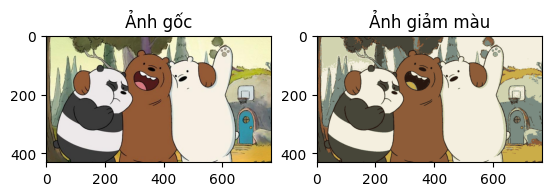

In [136]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data_Arr)
axes[0].set_title('Ảnh gốc')
axes[1].imshow(new_Arr)
axes[1].set_title('Ảnh giảm màu')

Text(0.5, 1.0, 'Ảnh thay đổi size')

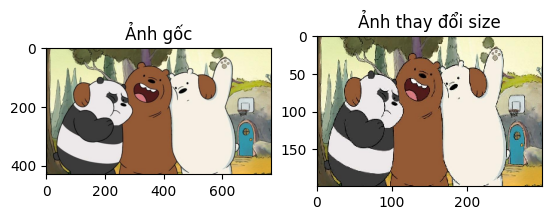

In [137]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data_Arr)
axes[0].set_title('Ảnh gốc')
axes[1].imshow(resize_img(data_Arr, height_Change, width_Change))
axes[1].set_title('Ảnh thay đổi size')